In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(168528, 109)



# Triage Accuracy

(how many patients did they get right and do they do it in the right order; ie, Still or obvious life threat first (Red, Gray, Black), then wavers, then walkers last)



## Did they get it right?

In [4]:

# Show all combinations of the treated/wrongly columns
columns_list = [
    'injury_record_injury_treated_with_wrong_treatment', 'injury_record_injury_treated',
    'injury_treated_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated'
]
df = frvrs_logs_df[columns_list].drop_duplicates()
for cn in columns_list:
    print()
    print(cn)
    display(df[cn].unique().tolist())
    mask_series = ~frvrs_logs_df[cn].isnull()
    display(frvrs_logs_df[mask_series].sample(min(4, frvrs_logs_df[mask_series].shape[0])).dropna(axis='columns', how='all').T)


injury_record_injury_treated_with_wrong_treatment


[nan, False]

,137824,30341,80444,80463
action_type,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD
elapsed_time,420890,259848,272360,272360
event_time,2023-04-21 12:32:00,2023-03-07 10:32:00,2023-05-11 10:36:00,2023-05-11 10:36:00
session_uuid,3bac8365-232a-4be0-a551-c5214b9f0706,400b6351-6f35-4f5b-98a6-db100a2fefd8,8581c1f8-a4e8-4245-ac73-2bd671237001,8581c1f8-a4e8-4245-ac73-2bd671237001
file_name,clean-max15.csv,Clean Marty12.csv,clean-8581c1f8-a4e8-4245-ac73-2bd671237001.csv,clean-8581c1f8-a4e8-4245-ac73-2bd671237001.csv
logger_version,1.0,1.0,1.0,1.0
time_group,2,2,2,2
injury_record_id,R Shin Amputation,R Side Puncture,L Wrist Amputation,L Thigh Puncture
injury_record_patient_id,Bob_0 Root,Mike_5 Root,Bob_0 Root,Mike_7 Root
injury_record_required_procedure,tourniquet,woundpack,tourniquet,tourniquet



injury_record_injury_treated


[nan, False]

,128488,159120,88835,22458
action_type,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD
elapsed_time,11029,22541,228213,7188334
event_time,2023-05-09 09:59:00,2023-09-07 12:07:49,2023-05-31 09:06:00,2023-05-16 18:14:00
session_uuid,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,b0f6e371-e548-4e1d-adc1-92891a6ca6ca,9179223d-a6e0-4612-8200-40f30d05c11e,724fdf45-3165-43b8-b9ca-dc07102d2886
file_name,clean-ff97fc56-c803-4aa7-b419-35e0ac17d0b3.csv,b0f6e371-e548-4e1d-adc1-92891a6ca6ca.csv,clean-9179223d-a6e0-4612-8200-40f30d05c11e.csv,Clean 724fdf45-3165-43b8-b9ca-dc07102d2886.csv
logger_version,1.0,1.3,1.0,1.0
time_group,1,1,2,17
injury_record_id,R Chest Collapse,R Side Puncture,L Side Puncture,Face Shrapnel
injury_record_patient_id,Mike_3 Root,Military Mike Jungle Combat_2_0 Root,Lily_4 Root,Gary_1 Root
injury_record_required_procedure,decompress,woundpack,woundpack,airway



injury_treated_injury_treated_with_wrong_treatment


[nan, False, True]

,142067,95278,38189,107195
action_type,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED
elapsed_time,481242,1523708,99730,426334
event_time,2023-04-21 12:02:00,2023-05-09 08:35:00,2023-03-07 13:50:00,2023-05-10 11:47:00
session_uuid,efed5e1c-4427-47df-8e3f-9e4714880169,9d142377-69d6-4622-958d-a29a6a0a0d21,ee8a8276-1a9c-41fd-a793-a3eb6d337ff7,b0a0d36e-4fb8-43b7-a966-d730e1130945
file_name,clean-max17.csv,clean-9d142377-69d6-4622-958d-a29a6a0a0d21.csv,Clean Marty21.csv,clean-b0a0d36e-4fb8-43b7-a966-d730e1130945.csv
logger_version,1.0,1.0,1.0,1.0
time_group,2,3,1,2
injury_treated_id,L Side Puncture,R Calf Laceration,L Shoulder Puncture,R Calf Laceration
injury_treated_patient_id,Lily_4 Root,Mike_7 Root,Mike_2 Root,Mike_7 Root
injury_treated_required_procedure,woundpack,gauzePressure,woundpack,gauzePressure



injury_treated_injury_treated


[nan, True, False]

,144051,88098,11857,105455
action_type,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED
elapsed_time,300690,1010051,595887,457566
event_time,2023-04-21 11:03:00,2023-05-09 09:09:00,2023-05-16 16:25:00,2023-05-10 11:13:00
session_uuid,3435501b-192a-457f-9763-7985f7975784,8f6097ce-795d-483a-a811-e6a5423bc59d,724fdf45-3165-43b8-b9ca-dc07102d2886,a1cb9dd5-e62b-4085-99d8-688e0a3856ee
file_name,clean-max4.csv,clean-8f6097ce-795d-483a-a811-e6a5423bc59d.csv,Clean 724fdf45-3165-43b8-b9ca-dc07102d2886.csv,clean-a1cb9dd5-e62b-4085-99d8-688e0a3856ee.csv
logger_version,1.0,1.0,1.0,1.0
time_group,1,2,2,2
injury_treated_id,R Forearm Laceration,L Forearm Laceration,R Side Puncture,L Thigh Puncture
injury_treated_patient_id,Mike_0 Root,Gloria_8 Root,Mike_5 Root,Mike_7 Root
injury_treated_required_procedure,gauzePressure,gauzePressure,woundpack,tourniquet


In [5]:

# Create a list of the columns to group by
groupby_columns = ['session_uuid', 'time_group', 'patient_id']

# Group the frvrs_logs_df dataframe by the groupby columns
gb = frvrs_logs_df.sort_values(['elapsed_time']).groupby(groupby_columns)

# Initialize an empty list to store rows
rows_list = []

# Iterate over the grouped dataframe
for (session_uuid, time_group, patient_id), df1 in gb:
    
    # Get the logger version for the current group
    logger_version = df1.logger_version.unique().item()

    # Iterate over the possible values for the two columns
    for wrong in [True, False]:
        for eventually in [True, False]:
            
            # Create a dictionary to store the results for the current group
            row_dict = {}
            
            # Add the logger version to the row dictionary
            row_dict['logger_version'] = logger_version
            
            # Populate the row_dict with values from the groupby_columns
            for cn in groupby_columns: row_dict[cn] = eval(cn)
            
            # Add the current values of the two columns to the row dictionary
            row_dict['injury_treated_injury_treated_with_wrong_treatment'] = wrong
            row_dict['injury_treated_injury_treated'] = eventually

            # Initialize a filter rows to add conditions via a loop
            mask_series = True

            # Add conditions for each column in groupby_columns
            for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
            
            # Add the two columns to the mask series
            mask_series &= (frvrs_logs_df.injury_treated_injury_treated_with_wrong_treatment == wrong)
            mask_series &= (frvrs_logs_df.injury_treated_injury_treated == eventually)

            # Calculate the unique patient count for the filtered rows
            row_dict['patient_count'] = frvrs_logs_df[mask_series].patient_id.unique().shape[0]

            # Add the row dictionary to the rows list
            rows_list.append(row_dict)

# Create a DataFrame from the list of rows
patient_count_df = DataFrame(rows_list)

In [6]:

mask_series = (patient_count_df.patient_count > 0)
columns_list = [
    'injury_treated_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated'
]
df = patient_count_df[mask_series]
display(df[columns_list].drop_duplicates())
display(df.sample(min(4, patient_count_df[mask_series].shape[0])).dropna(axis='columns', how='all').T)
display(df.groupby(columns_list).sum().patient_count.to_frame())
mask_series = (df.injury_treated_injury_treated == True)
display(df[mask_series].groupby('injury_treated_injury_treated_with_wrong_treatment').sum().patient_count.to_frame())

,injury_treated_injury_treated_with_wrong_treatment,injury_treated_injury_treated
38,False,True
305,True,False
408,True,True


,6606,10090,11598,1102
logger_version,1.0,1.3,1.3,1.0
session_uuid,7a1065f6-1a05-4d2b-bf14-73cafdb9ce4b,b11f14c2-8de9-4247-9753-1434cb392804,d0f826d3-a6db-4a6a-9ceb-5e17e3ff3d17,0b891add-e0c3-463d-948d-7f491f1d10ef
time_group,1,1,2,5
patient_id,Mike_3 Root,Tutorial Military Marine Root,Marine with Leg Amputation Root,Mike_13 Root
injury_treated_injury_treated_with_wrong_treatment,False,False,False,False
injury_treated_injury_treated,True,True,True,True
patient_count,1,1,1,1


patient_count
injury_treated_injury_treated_with_wrong_treatment injury_treated_injury_treated               
False                                              True                                    1176
True                                               False                                    124
                                                   True                                     105

,patient_count
injury_treated_injury_treated_with_wrong_treatment,
False,1176
True,105


In [7]:

# mask_series = (frvrs_logs_df.injury_treated_injury_treated_with_wrong_treatment == wrong)
# base_mask_series = (frvrs_logs_df.injury_treated_injury_treated == True)

# Create a list of the columns to group by
groupby_columns = ['session_uuid', 'time_group']

# Group the patient count data frame by the groupby columns
gb = patient_count_df.groupby(groupby_columns)

# Initialize an empty list to store rows
rows_list = []

# Iterate over the grouped dataframe
for (session_uuid, time_group), df1 in gb:
    
    # Create a dictionary to store the results for the current group
    row_dict = {}
    
    # Get the logger version for the current group
    logger_version = df1.logger_version.unique().item()
    
    # Add the logger version to the row dictionary
    row_dict['logger_version'] = logger_version
    
    # Populate the row_dict with values from the groupby_columns
    for cn in groupby_columns: row_dict[cn] = eval(cn)
    
    # Count all the patients up
    mask_series = True
    for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
    row_dict['patient_count'] = frvrs_logs_df[mask_series].patient_id.unique().shape[0]
    
    # Create a filter to get all treated patients and count them up
    mask_series = (df1.injury_treated_injury_treated == True)
    row_dict['treated_count'] = df1[mask_series].patient_count.sum()
    
    # Create a filter to get all rightly treated patients and count them up
    mask_series = (df1.injury_treated_injury_treated == True) & (df1.injury_treated_injury_treated_with_wrong_treatment == False)
    row_dict['rightly_treated_count'] = df1[mask_series].patient_count.sum()
    
    # Create a filter to get all wrongly treated patients and count them up
    mask_series = (df1.injury_treated_injury_treated_with_wrong_treatment == True)
    row_dict['mistaken_attempts_count'] = df1[mask_series].patient_count.sum()
    
    # Add the row dictionary to the rows list
    rows_list.append(row_dict)

# Create a DataFrame from the list of rows
rightly_treated_count_df = DataFrame(rows_list)

In [8]:

# Visualize some mistaken attempts
mask_series = (rightly_treated_count_df.mistaken_attempts_count > 0)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,303,132,315,167
logger_version,1.0,1.0,1.0,1.0
session_uuid,b878d528-37a0-4175-a294-16c4de1fd5eb,5aca0157-02d0-4409-a4fe-f64d03fd34a1,c993d63e-166e-45fa-9cb3-07908a234428,724fdf45-3165-43b8-b9ca-dc07102d2886
time_group,2,1,2,5
patient_count,12,13,12,15
treated_count,7,5,7,4
rightly_treated_count,6,4,6,4
mistaken_attempts_count,2,1,2,1


In [9]:

# Are there more treated patients than possible?
mask_series = (rightly_treated_count_df.treated_count > rightly_treated_count_df.patient_count)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

""


In [10]:

# Are there more rightly treated patients than treated patients?
mask_series = (rightly_treated_count_df.rightly_treated_count > rightly_treated_count_df.patient_count)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

""


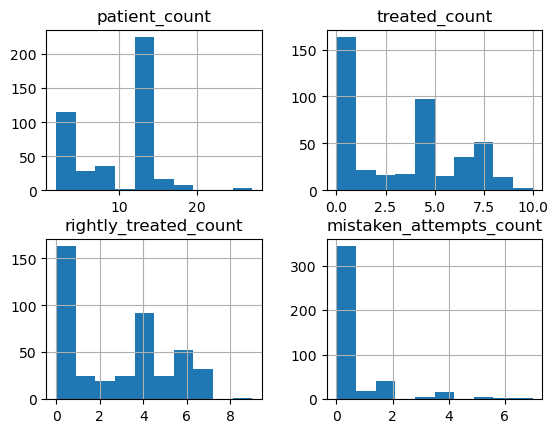

In [11]:

# Visualize the distributions
columns_list = ['patient_count', 'treated_count', 'rightly_treated_count', 'mistaken_attempts_count']
rightly_treated_count_df[columns_list].hist();



## Did they do it in the right order?

(Red, Gray, Black), then wavers, then walkers last

In [12]:

# Investigate the presence of black
srs = frvrs_logs_df.applymap(lambda x: 'black' in str(x).lower(), na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
columns_list

['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']

In [13]:

# Investigate the presence of wave
srs = frvrs_logs_df.applymap(lambda x: 'wave' in str(x).lower(), na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
columns_list

['action_type', 'patient_demoted_sort', 'patient_record_sort', 'voice_capture_message', 'voice_command_message', 'voice_command_command_description', 's_a_l_t_wave_if_can_sort_command_text', 's_a_l_t_waved_sort_command_text', 'patient_engaged_sort']

In [14]:

# Create a dataset of measures of right ordering
import statsmodels.api as sm

groupby_columns = ['session_uuid', 'time_group']
gb = frvrs_logs_df.groupby(groupby_columns)
rows_list = []
for (session_uuid, time_group), df1 in gb:
    row_dict = {}
    
    # Add the logger version for the current group
    logger_version = df1.logger_version.unique().item()
    row_dict['logger_version'] = logger_version
    
    # Populate the row_dict with values from the groupby_columns
    for cn in groupby_columns: row_dict[cn] = eval(cn)

    # Get the last engagement time among all the obvious life threats
    assert ('tag_applied_type' in df1.columns)
    mask_series = df1.tag_applied_type.isin(['red', 'gray', 'black'])
    df = df1[mask_series]
    if df.shape[0]:
        # display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)
        patient_ids_list = df.patient_id.unique().tolist()
        mask_series = True
        for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
        mask_series &= frvrs_logs_df.patient_id.isin(patient_ids_list)
        mask_series &= (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
        row_dict['last_threat_engaged'] = frvrs_logs_df[mask_series].elapsed_time.max()

    # Group the patients by engagement SORT category and get lists of their elapsed times
    engaged_sort_dict = {}
    for patient_engaged_sort, df2 in df1.groupby('patient_engaged_sort'):
        if patient_engaged_sort in ['still', 'waver', 'walker']:
            patient_ids_list = df2.patient_id.unique().tolist()
            mask_series = True
            for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
            mask_series &= frvrs_logs_df.patient_id.isin(patient_ids_list)
            mask_series &= (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
            row_dict[f'last_{patient_engaged_sort}_engaged'] = frvrs_logs_df[mask_series].elapsed_time.max()
            engaged_sort_dict[patient_engaged_sort] = frvrs_logs_df[mask_series].sort_values('elapsed_time').elapsed_time.tolist()
    
    # Get an R-squared Adjusted as a measure of right ordering
    ideal_sequence = []
    for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
    ideal_sequence = pd.Series(data=ideal_sequence)
    actual_sequence = ideal_sequence.sort_values(ascending=True)
    X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
    if X.shape[0]:
        X1 = sm.add_constant(X)
        try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
        except: rsquared_adj = np.nan
        row_dict['rsquared_adj'] = rsquared_adj
    
    rows_list.append(row_dict)

engagment_sort_df = DataFrame(rows_list)

In [15]:

df = engagment_sort_df.copy()
display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

,186,434,231,4
logger_version,1.0,1.0,1.3,1.0
session_uuid,7994d633-9b4d-475e-8e49-51cb6e4fea4b,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,8b979d02-dbea-4d22-864b-7031425815cb,06574b6f-ab02-432c-9a65-7b031218a270
time_group,0,2,1,1
last_threat_engaged,NaN,385123.0,406251.0,295168.0
last_still_engaged,NaN,274232.0,475692.0,91120.0
last_walker_engaged,NaN,499888.0,NaN,343840.0
last_waver_engaged,NaN,420824.0,572199.0,176515.0
rsquared_adj,NaN,0.596156,-0.10217,1.0


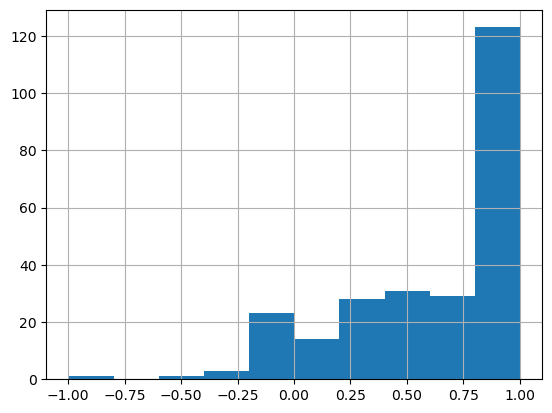

In [16]:

# The adjusted R-squared value of a linear regression model fit as a measure of
# how well trainees engaged the still first, then wavers, then walkers last
engagment_sort_df.rsquared_adj.hist();

In [17]:

# Verify that the stills were finished first
import numpy as np

def f(df):
    last_still_engaged = df.last_still_engaged
    last_walker_engaged = df.last_walker_engaged
    last_waver_engaged = df.last_waver_engaged
    min_engagement = min(last_still_engaged, last_walker_engaged, last_waver_engaged)

    return (last_still_engaged == min_engagement)
df = engagment_sort_df.copy()
df['stills_finished_first'] = df.apply(f, axis='columns')

# Create a mask where any of the last engaged columns are NaN and set the stills finished first column to NaN if true
columns_list = ['last_still_engaged', 'last_walker_engaged', 'last_waver_engaged']
mask_series = df[columns_list].isnull().any(axis='columns')
df.loc[mask_series, 'stills_finished_first'] = np.nan

mask_series = (df.stills_finished_first == False)
display(df[mask_series].sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,118,38,136,187
logger_version,1.0,1.0,1.0,1.0
session_uuid,4ce8ee9f-45ea-42a8-86df-0038c777f040,206da802-d38f-4f3a-98e3-44f99481479d,5c8b0274-379c-40ca-b6ff-b846f9e14ad5,7994d633-9b4d-475e-8e49-51cb6e4fea4b
time_group,1,2,2,1
last_threat_engaged,340220.0,1044978.0,825576.0,244625.0
last_still_engaged,340220.0,1044978.0,825576.0,98320.0
last_walker_engaged,448579.0,955411.0,785180.0,244625.0
last_waver_engaged,317739.0,867866.0,830588.0,66688.0
rsquared_adj,0.490358,0.109439,-0.017388,0.927403
stills_finished_first,False,False,False,False


In [18]:

max_rsquared_adj = df.rsquared_adj.max()
mask_series = df.rsquared_adj.isin([max_rsquared_adj])
display(df[mask_series].sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,198,357,284,189
logger_version,1.0,1.0,1.0,1.0
session_uuid,7de52180-d823-4f9e-9003-aeab8139970b,d66b46ee-9057-43d6-8108-179b83820a37,ad2137d0-d5aa-4a4e-af02-e327993c6d41,7a1065f6-1a05-4d2b-bf14-73cafdb9ce4b
time_group,1,2,1,1
last_threat_engaged,212649.0,508250.0,143561.0,175494.0
last_still_engaged,56434.0,405626.0,143561.0,97051.0
last_walker_engaged,212649.0,621882.0,329134.0,205480.0
last_waver_engaged,108854.0,563958.0,209147.0,134123.0
rsquared_adj,1.0,1.0,1.0,1.0
stills_finished_first,True,True,True,True


In [19]:

min_rsquared_adj = df.rsquared_adj.min()
mask_series = df.rsquared_adj.isin([min_rsquared_adj])
display(df[mask_series].sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,45
logger_version,1.0
session_uuid,274ce308-c366-4829-b9cc-d535b51d16d3
time_group,1
last_walker_engaged,102065.0
last_waver_engaged,88520.0
rsquared_adj,-0.997128


In [21]:

# In the worse-case scenario, the trainee was supposed to engage the waver first, then the two walkers
# Instead, they engaged one of the walkers, then a waver, then the other walker
session_uuid = '274ce308-c366-4829-b9cc-d535b51d16d3'
time_group = 1
engaged_sort_dict = {'walker': [54614, 102065], 'waver': [88520]}
ideal_sequence = []
for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
ideal_sequence = pd.Series(data=ideal_sequence)
actual_sequence = ideal_sequence.sort_values(ascending=True)
print(f'ideal_sequence = {ideal_sequence.tolist()}\nactual_sequence = {actual_sequence.tolist()}')
X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
X1 = sm.add_constant(X)
try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
except: rsquared_adj = np.nan
print(f'rsquared_adj = {rsquared_adj}')

ideal_sequence = [88520, 54614, 102065]
actual_sequence = [54614, 88520, 102065]
rsquared_adj = -0.9971283921806686
